# Exploring EAZY results

* Load and print results
* Galaxy card compiling color image and plots

Earendel + Sunrise Arc lensed by WHL0137:  
https://cosmic-spring.github.io/earendel.html  

Interactive color image + catalog explorer:  
https://cosmic-spring-jwst.herokuapp.com  

WHL0137 images and galaxy catalogs processed by grizli and EAZY:  
https://s3.amazonaws.com/grizli-v2/JwstMosaics/whl0137/arc-v2/index.html   

Color images:  
https://www.easyzoom.com/imageaccess/126a44c2acae47df81bee5c85c98d4c7  
https://stsci.box.com/s/cq992a7cfd13wlsmu784zkioho1pga65  

EAZY:  
https://eazy-py.readthedocs.io

## Imports

In [1]:
import eazy
import eazy.hdf5

In [2]:
from astropy.table import Table
import astropy.units as u
import astropy

# for labeling color image
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.wcs as wcs

In [3]:
# to show segmentation map
import photutils

In [4]:
import numpy as np
from glob import glob
import string
from importlib import reload

import os
from os.path import expanduser
home = expanduser("~")

In [5]:
# color images
import PIL
from PIL import Image, ImageDraw, ImageFont
PIL.Image.MAX_IMAGE_PIXELS = 933120000  # allow to load large images avoiding DecompressionBombError

In [6]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
#%matplotlib inline   # non-interactive (easier for notebook scrolling)
%matplotlib notebook
#plt.style.use(os.path.join(home, 'p', 'matplotlibrc.txt')) # https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MultipleLocator

## Helper functions

In [7]:
def extract_id(cat, id, idlabel='id'): # choose_object select_object
    # Note input id must be same format as cat[idlabel] (int or string)
    # to create an array with mostly False entries and True for id
    # cat['id'] dtype='int64'
    # cat['id'] == 3: [False, False, True, False...]
    # cat['id'] == '3': False
    #
    # obj:          astropy.table.table.Table
    # obj[0]:       astropy.table.row.Row
    # obj['id']:    astropy.table.column.Column
    # obj[0]['id']: numpy.int64
    duck_duck_goose = cat[idlabel] == int(id)
    if len(duck_duck_goose):
        obj = cat[duck_duck_goose]
    return obj[0]

In [8]:
def find_object_in_catalog(RA, Dec):
    object_coordinates = SkyCoord(ra=RA*u.deg, dec=Dec*u.deg)
    
    # First look in segmentation map:
    x, y = image_wcs.world_to_pixel(object_coordinates)
    x = roundint(x)
    y = roundint(y)
    id = segm.data[y,x]
    
    # If nothing there, check for nearby object
    if not id:
        catalog_coordinates = SkyCoord(ra=eazy_results['ra'], dec=eazy_results['dec'])  # *u.deg
        idx, d2d, d3d = object_coordinates.match_to_catalog_sky(catalog_coordinates)
        id = eazy_results['id'][idx]
    
    return id

In [9]:
def between(lo, x, hi, tol=0):
    return (lo-tol < x) & (x < hi+tol)

def roundint(x):
    return np.round(x).astype(int)

In [10]:
# Format exponential ticks to read as simple numbers unless too big / small
def fmtexp(x, pos):
    if between(1e-4, x, 1e4):
        s = '%g' % x
    else:
        p = int(np.log10(x))
        d = int(np.round(x / 10**p))
        #print d
        s = ''
        if d > 1:
            s += '%d$\\times$' % d
    
        s += '10${\\mathdefault{^{%d}}}$' % p
    return s

# Conversions for second axis
def AB2uJy(mAB):
    m = mAB * u.ABmag
    f = m.to(u.uJy)
    return f.value

def uJy2AB(F_uJy):
    f = F_uJy * u.uJy
    m = f.to(u.ABmag)
    return m.value

def AB2nJy(mAB):
    m = mAB * u.ABmag
    f = m.to(u.nJy)
    return f.value

def nJy2AB(F_nJy):
    f = F_nJy * u.nJy
    m = f.to(u.ABmag)
    return m.value

## more functions to show galaxy results

In [11]:
def slices_extent(x, y, dx, dy=0):
    dy = dy or dx
    xlo = roundint(x-dx)
    xhi = roundint(x+dx+1)
    ylo = roundint(y-dy)
    yhi = roundint(y+dy+1)
    xslice = slice(xlo, xhi)
    yslice = slice(ylo, yhi)
    slices = yslice, xslice
    extent = xlo, xhi, ylo, yhi
    return slices, extent

In [12]:
# Show color image and segment
def show_galaxy(id, figsize=(6,3)):
    global obj, xlo, xhi, ylo, yhi, cmap
    obj = extract_id(eazy_results, id)
    x = obj['x']
    y = obj['y']
    dx = dy = 100
    #xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
    slices, extent = slices_extent(x, y, dx, dy)
    xlo, xhi, ylo, yhi = extent

    cmap = segm.make_cmap(seed=12345)
    cmap_colors = cmap.colors[:]
    cmap_colors[0]  = np.array([1, 1, 1])  # white background
    cmap_colors[id] = np.array([0, 0, 0])  # black selected object
    cmap = ListedColormap(cmap_colors)

    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(color_image[slices], extent=extent)
    plt.xlabel('')
    plt.ylabel('')
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    ax2 = fig.add_subplot(1,2,2)
    plt.imshow(segm.data, cmap=cmap)
    plt.xlim(xlo,xhi)
    plt.ylim(ylo,yhi)
    plt.xlabel('')
    plt.ylabel('')
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)
    fig.tight_layout()
    
    return fig

In [13]:
def plot_SED(id, fig, ax, plot_flux_units=u.uJy, plot_wavelength_units=u.um, rest_lam_interval=1000,
             obs_color='c', SED_color='brown', model_color='brown', model_lw = 0.7, model_alpha = 0.7):

    data = eazy_obj_data = eazy_run.show_fit(id, show_fnu=True, get_spec=True)
    z_phot = eazy_obj_data['z']  # photo-z
    #id = eazy_obj_data['id']
    #ix = eazy_obj_data['ix']
    #z = eazy_run.zgrid
    #pz = np.exp(eazy_run.lnp[ix]).flatten()

    #obj = extract_id(eazy_results, id)

    #eazy_flux_units = u.erg / u.s / u.cm**2 / u.AA

    data['flux_unit']
    data['wave_unit']
    
    wavelengths  = (data['pivot'] * data['wave_unit']).to(plot_wavelength_units)
    #fluxes       = (data['fobs']  * eazy_flux_units).to(plot_flux_units, u.spectral_density(wavelengths))
    fluxes       = (data['fobs']  * data['flux_unit']).to(plot_flux_units)
    flux_errs    = (data['efobs'] * data['flux_unit']).to(plot_flux_units)
    model_fluxes = (data['model'] * data['flux_unit']).to(plot_flux_units)
    #model_fluxes = data['model'] * u.uJy

    # Missing data
    missing  = (data['fobs']  < eazy_run.param['NOT_OBS_THRESHOLD']) 
    missing |= (data['efobs'] < 0)

    snr_thresh = 1
    SNR = data['fobs'] / data['efobs']
    detected     = (~missing) & (SNR >  snr_thresh)
    not_detected = (~missing) & (SNR <= snr_thresh)

    # Plot y scale
    goodflux = fluxes > flux_errs

    flux_min = np.min(fluxes[detected].value)
    flux_max = np.max(fluxes[goodflux].value)

    model_flux_max = np.max(model_fluxes.value)
    model_flux_min = np.min(model_fluxes.value)

    if np.any(not_detected):
        upper_limits = flux_errs[not_detected].value
        upper_limit_min = np.min(upper_limits)
        flux_min = np.min([flux_min, upper_limit_min])

    flux_max = np.max([flux_max, model_flux_max])
    #if plot_full_spec:
    #    flux_max = np.max([flux_max, spec_max])

    if 0: # plot linear not implemented here
        flux_margin = 0.1 * (flux_max - flux_min)
        yhi = flux_max + flux_margin * 2
        ylo = flux_min - flux_margin
    else:
        yhi = flux_max * 1
        ylo = flux_min / 2


    #fig, ax = plt.subplots(figsize=(8, 5))

    # Observed flux error bars
    plt.errorbar(wavelengths[detected], fluxes[detected], flux_errs[detected],
                 ms=8, marker='o', mfc=obs_color, c='k', lw=3, alpha=0.5, ls='none')

    # Observed fluxes
    #plt.plot(wavelengths[detected], fluxes[detected],       'o', color=obs_color,   ms=8,  
    #         label='Input fluxes', zorder=10)#, scaley=False)

    # Model fluxes
    plt.plot(wavelengths[detected], model_fluxes[detected], 's', color=model_color, ms=10, mfc='None', 
             label='Model fluxes', zorder=10)#, scaley=False)

    #plt.semilogx()
    plt.semilogy()

    #plt.margins(1)
    ax.autoscale(False)
    
    # Non detections
    plt.plot(wavelengths[not_detected], flux_errs[not_detected],
             ms=8, marker='v', mfc=obs_color, c='k', lw=3, alpha=0.5, ls='none')

    # SED
    SED_wavelength = (data['templz'] * u.AA).to(u.um)
    SED_flux = data['templf'] * u.uJy
    plt.plot(SED_wavelength, SED_flux, '-', color=model_color, lw=model_lw, alpha=model_alpha, zorder=-10)

    plt.xlabel('Wavelength ($\mu$m)')
    plt.ylabel('Flux ($\mu$Jy)')

    #ax.yaxis.set_major_formatter(ticker.FuncFormatter(fmtexp))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
    ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%g"))
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(subs=(1,2,3,5,7)))

    secax = ax.secondary_yaxis('right', functions=(uJy2AB, AB2uJy))
    #secax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
    secax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%g"))
    secax.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%g"))
    secax.set_ylabel('Magnitude (AB)')

    topax = add_rest_wavelength_axis(ax, z_phot, rest_lam_interval=rest_lam_interval)
    
    
def add_rest_wavelength_axis(ax, z, rest_units=1000*u.AA, rest_lam_interval=1000, obs_lam_interval=1):
    factor = u.um.to(rest_units)
    def bottom2top(x): return x / (1+z) * factor
    def top2bottom(x): return x * (1+z) / factor
    ax.xaxis.set_major_locator(ticker.MultipleLocator(obs_lam_interval))  # Original bottom axis (microns)
    topax = ax.secondary_xaxis('top', functions=(bottom2top, top2bottom))
    tick_locator = (rest_lam_interval*u.AA / rest_units).value
    topax.xaxis.set_major_locator(ticker.MultipleLocator(tick_locator))  # New top axis
    xticks = topax.get_xticks()
    xmin1, xmax1 = ax.get_xlim()
    xmax2 = bottom2top(xmax1)
    if xmax2 > 25:
        tick_locator *= (xmax2 // 25 + 1)
        topax.xaxis.set_major_locator(ticker.MultipleLocator(tick_locator))  # New top axis
    #rest_label = 'Rest Wavelength ($1000 \AA$)'
    rest_label = 'Rest Wavelength ($%d \\rm{\AA}$)' % rest_units.value
    if rest_units.value == 1:
        rest_label = 'Rest Wavelength ($\\rm{\AA}$)' % rest_units.value
    topax.set_xlabel(rest_label, fontsize=14)
    return topax

In [14]:
# Plot log(1+z)

def z2log(z):
    return np.log10(1+z)

def log2z(log1z):
    return 10 ** log1z - 1

In [15]:
def show_galaxy_properties(id, hist_color='C0', figsize=(12, 6), save=False):
    data = eazy_obj_data = eazy_run.show_fit(id, show_fnu=True,get_spec=True)
    #id = eazy_obj_data['id']
    ix = eazy_obj_data['ix']
    z = eazy_run.zgrid
    pz = np.exp(eazy_run.lnp[ix]).flatten()

    obj = extract_id(eazy_results, id)

    # Load data
    x = obj['x']
    y = obj['y']
    dx = dy = 100
    #xlo, xhi, ylo, yhi = x-dx, x+dx, y-dy, y+dy
    slices, extent = slices_extent(x, y, dx, dy)
    xlo, xhi, ylo, yhi = extent

    cmap = segm.make_cmap(seed=12345)
    cmap_colors = cmap.colors[:]
    cmap_colors[0]  = np.array([1, 1, 1])  # white background
    cmap_colors[id] = np.array([0, 0, 0])  # black selected object
    cmap = ListedColormap(cmap_colors)

    # Create figure and gridspec
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 6, wspace=0)  # nrows, ncolumns

    # Color image
    #ax1 = fig.add_subplot(3,6,1)  # nrows, ncolumns, index
    ax1 = fig.add_subplot(gs[0,0])
    ax1.imshow(color_image[slices], extent=extent)
    #plt.xlim(xlo, xhi)
    #plt.ylim(ylo, yhi)
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    # Segmentation map
    #ax2 = fig.add_subplot(3,6,2)  # nrows, ncolumns, index
    ax2 = fig.add_subplot(gs[0,1])
    #plt.imshow(segm.data[slices], extent=extent, cmap=cmap)
    plt.imshow(segm.data, cmap=cmap)
    plt.xlim(xlo,xhi)
    plt.ylim(ylo,yhi)
    #plt.xlim(xlo, xhi)
    #plt.ylim(ylo, yhi)
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)

    # Redshift
    gs3 = fig.add_gridspec(100, 3, wspace=0.2)  # nrows, ncolumns
    ax3 = fig.add_subplot(gs3[45:50,0])
    #plt.hist(fit.posterior.samples['redshift'], ec=colors[0], lw=3)
    #plt.plot(z, pz, color=colors[0], lw=3)
    #plt.fill_between(z, pz, pz*0, color=hist_color)
    plt.fill_between(z2log(z), pz, pz*0, color=hist_color)

    ztx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 15, 20]
    zmax = np.max(z)
    #ztx_minor = 0.2, 0.4, 0.6, 0.8, 9, 11, 12, 13
    ztx_minor = np.arange(0.2,1,0.2)
    ztx_minor = set(ztx_minor) | set(np.arange(zmax)).difference(ztx)
    ztx_minor = list(ztx_minor)
    plt.xlim(0, z2log(zmax))
    #ax3.xaxis.tick_bottom()
    plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, labelleft=False)
    sec_xax = ax3.secondary_xaxis('top', functions=(log2z, z2log))
    sec_xax.set_xticks(ztx)
    sec_xax.set_xticks(ztx_minor, minor=True)
    sec_xax.set_xlabel('Redshift', fontsize=16)        

    
    # specific SFR (sSFR)
    ax3b = fig.add_subplot(gs3[70:75,0])
    ssfr_percentiles = extract_id(eazy_results, id)['ssfr_p']
    log_ssfr_Gyr_p = np.log10(ssfr_percentiles) + 9
    #plt.hist(log_sSFR, ec=colors[0], lw=3)
    #for log_ssfr_Gyr in log_ssfr_Gyr_p:
    #    plt.axvline(log_ssfr_Gyr, color=colors[0], lw=1)
    #print(log_ssfr_Gyr_p[0], log_ssfr_Gyr_p[-1])
    if np.isnan(log_ssfr_Gyr_p[-1]):
        log_ssfr_Gyr_p[0] = log_ssfr_Gyr_p[-1] = -4
    plt.fill_betweenx([0,1], log_ssfr_Gyr_p[0], log_ssfr_Gyr_p[-1], color=hist_color)
    plt.xlim(-4, +1)
    plt.ylim(0,1)
    ax3b.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3b.xaxis.tick_top()
    ax3b.axes.yaxis.set_visible(False)
    #ax3b.set_title('log sSFR ( / Myr)', fontsize=16)
    ax3b.set_title('log sSFR (Gyr$^{-1}$)', fontsize=16)

    # Dust
    ax3c = fig.add_subplot(gs3[95:100, 0])
    dust_percentiles = extract_id(eazy_results, id)['Av_p']
    plt.fill_betweenx([0,1], dust_percentiles[0], dust_percentiles[-1], color=hist_color)
    #for dust in dust_percentiles:
    #    plt.axvline(dust, color='c', lw=1)
    #plt.xlim(dust["Av"][0], dust["Av"][1])
    plt.xlim(0, 3)
    plt.ylim(0, 1)
    ax3c.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax3c.xaxis.tick_top()
    ax3c.axes.yaxis.set_visible(False)
    ax3c.set_title('dust $A_V$ (mag)', fontsize=16)

    # SED
    gs4 = fig.add_gridspec(1, 3)  ## nrows, ncolumns
    ax4 = fig.add_subplot(gs4[0,1:])
    #plt1, fig1, ax1, secax = 
    plot_SED(id, fig, ax4)

    if save:
        fig.savefig('EAZY_%d.png' % id)
    
    return fig

# START HERE

# Load EAZY results

In [16]:
inroot = 'sunrise-grizli-v2-fix'
field = 'whl0137'

In [17]:
eazy_file = inroot + '.eazypy.zout.fits'
eazy_results = Table.read(eazy_file)
eazy_results[:2]

id,ra,dec,z_spec,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,Lv,mass,sfr,LIR,energy_abs,Av,lw_age_V,MLv,Lv_p,mass_p,LIR_p,sfr_p,Av_p,ssfr_p
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solLum,solMass,solMass / yr,solLum,solLum,,Gyr,solMass / solLum,solLum,solMass,solLum,solMass / yr,,1 / yr
int32,float64,float64,float64,int64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5]
1,24.387902081394042,-8.500793054092345,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,0.0e+00,-9.00e+29,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-99.00,-900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.000 .. -900000000000000046043660025856.000,-900000000000000046043660025856.00 .. -900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29
2,24.371328269240365,-8.500794091836365,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,0.0e+00,-9.00e+29,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-99.00,-900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.000 .. -900000000000000046043660025856.000,-900000000000000046043660025856.00 .. -900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29


In [18]:
eazy_phot = Table.read(inroot + '_phot_apcorr.fits')
eazy_phot[:2]

id,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2_image,y2_image,xy_image,errx2,erry2,errxy,a_image,b_image,theta_image,cxx_image,cyy_image,cxy_image,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,x_image,y_image,number,ra,dec,x_world,y_world,flux_iso,fluxerr_iso,area_iso,mag_iso,kron_radius,kron_rcirc,flux_auto,fluxerr_auto,bkg_auto,flag_auto,area_auto,flux_radius_flag,flux_radius_20,flux_radius,flux_radius_90,tot_corr,mag_auto,magerr_auto,flux_aper_0,fluxerr_aper_0,flag_aper_0,bkg_aper_0,mask_aper_0,flux_aper_1,fluxerr_aper_1,flag_aper_1,bkg_aper_1,mask_aper_1,flux_aper_2,fluxerr_aper_2,flag_aper_2,bkg_aper_2,mask_aper_2,f090w-clear_flux_aper_0,f090w-clear_fluxerr_aper_0,f090w-clear_flag_aper_0,f090w-clear_bkg_aper_0,f090w-clear_mask_aper_0,f090w-clear_flux_aper_1,f090w-clear_fluxerr_aper_1,f090w-clear_flag_aper_1,f090w-clear_bkg_aper_1,f090w-clear_mask_aper_1,f090w-clear_flux_aper_2,f090w-clear_fluxerr_aper_2,f090w-clear_flag_aper_2,f090w-clear_bkg_aper_2,f090w-clear_mask_aper_2,f090w-clear_tot_corr,f105w_flux_aper_0,f105w_fluxerr_aper_0,f105w_flag_aper_0,f105w_bkg_aper_0,f105w_mask_aper_0,f105w_flux_aper_1,f105w_fluxerr_aper_1,f105w_flag_aper_1,f105w_bkg_aper_1,f105w_mask_aper_1,f105w_flux_aper_2,f105w_fluxerr_aper_2,f105w_flag_aper_2,f105w_bkg_aper_2,f105w_mask_aper_2,f105w_tot_corr,f110w_flux_aper_0,f110w_fluxerr_aper_0,f110w_flag_aper_0,f110w_bkg_aper_0,f110w_mask_aper_0,f110w_flux_aper_1,f110w_fluxerr_aper_1,f110w_flag_aper_1,f110w_bkg_aper_1,f110w_mask_aper_1,f110w_flux_aper_2,f110w_fluxerr_aper_2,f110w_flag_aper_2,f110w_bkg_aper_2,f110w_mask_aper_2,f110w_tot_corr,f115w-clear_flux_aper_0,f115w-clear_fluxerr_aper_0,f115w-clear_flag_aper_0,f115w-clear_bkg_aper_0,f115w-clear_mask_aper_0,f115w-clear_flux_aper_1,f115w-clear_fluxerr_aper_1,f115w-clear_flag_aper_1,f115w-clear_bkg_aper_1,f115w-clear_mask_aper_1,f115w-clear_flux_aper_2,f115w-clear_fluxerr_aper_2,f115w-clear_flag_aper_2,f115w-clear_bkg_aper_2,f115w-clear_mask_aper_2,f115w-clear_tot_corr,f125w_flux_aper_0,f125w_fluxerr_aper_0,f125w_flag_aper_0,f125w_bkg_aper_0,f125w_mask_aper_0,f125w_flux_aper_1,f125w_fluxerr_aper_1,f125w_flag_aper_1,f125w_bkg_aper_1,f125w_mask_aper_1,f125w_flux_aper_2,f125w_fluxerr_aper_2,f125w_flag_aper_2,f125w_bkg_aper_2,f125w_mask_aper_2,f125w_tot_corr,f140w_flux_aper_0,f140w_fluxerr_aper_0,f140w_flag_aper_0,f140w_bkg_aper_0,f140w_mask_aper_0,f140w_flux_aper_1,f140w_fluxerr_aper_1,f140w_flag_aper_1,f140w_bkg_aper_1,f140w_mask_aper_1,f140w_flux_aper_2,f140w_fluxerr_aper_2,f140w_flag_aper_2,f140w_bkg_aper_2,f140w_mask_aper_2,f140w_tot_corr,f150w-clear_flux_aper_0,f150w-clear_fluxerr_aper_0,f150w-clear_flag_aper_0,f150w-clear_bkg_aper_0,f150w-clear_mask_aper_0,f150w-clear_flux_aper_1,f150w-clear_fluxerr_aper_1,f150w-clear_flag_aper_1,f150w-clear_bkg_aper_1,f150w-clear_mask_aper_1,f150w-clear_flux_aper_2,f150w-clear_fluxerr_aper_2,f150w-clear_flag_aper_2,f150w-clear_bkg_aper_2,f150w-clear_mask_aper_2,f150w-clear_tot_corr,f160w_flux_aper_0,f160w_fluxerr_aper_0,f160w_flag_aper_0,f160w_bkg_aper_0,f160w_mask_aper_0,f160w_flux_aper_1,f160w_fluxerr_aper_1,f160w_flag_aper_1,f160w_bkg_aper_1,f160w_mask_aper_1,f160w_flux_aper_2,f160w_fluxerr_aper_2,f160w_flag_aper_2,f160w_bkg_aper_2,f160w_mask_aper_2,f160w_tot_corr,f200w-clear_flux_aper_0,f200w-clear_fluxerr_aper_0,f200w-clear_flag_aper_0,f200w-clear_bkg_aper_0,f200w-clear_mask_aper_0,f200w-clear_flux_aper_1,f200w-clear_fluxerr_aper_1,f200w-clear_flag_aper_1,f200w-clear_bkg_aper_1,f200w-clear_mask_aper_1,f200w-clear_flux_aper_2,f200w-clear_fluxerr_aper_2,f200w-clear_flag_aper_2,f200w-clear_bkg_aper_2,f200w-clear_mask_aper_2,f200w-clear_tot_corr,f277w-clear_flux_aper_0,f277w-clear_fluxerr_aper_0,f277w-clear_flag_aper_0,f277w-clear_bkg_aper_0,f277w-clear_mask_aper_0,f277w-clear_flux_aper_1,f277w-clear_fluxerr_aper_1,f277w-clear_flag_aper_1,f277w-clear_bkg_aper_1,f277w-clear_mask_aper_1,f277w-clear_flux_aper_2,f277w-clear_fluxerr_aper_2,f277w-clear_flag_aper_2,f277w-clear_bkg_aper_2,f277w-clear_mask_ape

In [19]:
eazy_data = fits.open(inroot + '.eazypy.data.fits')
eazy_data.info()

Filename: sunrise-grizli-v2-fix.eazypy.data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  ZBEST         1 ImageHDU         7   (16935,)   float32   
  2  ZGRID         1 ImageHDU         7   (294,)   float32   
  3  CHI2          1 ImageHDU        10   (294, 16935)   float32   
  4  COEFFS        1 ImageHDU        22   (12, 16935)   float32   


In the .h5 file, EAZY saved local paths to templates and FILTER.RES.latest.   
Link to them on your machine so we can find them now! For example:

ln /Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/eazy/data/templates   
ln /Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/eazy/data/filters/FILTER.RES.latest

In [20]:
# Load detailed results from h5 file
h5file  = inroot + '.eazypy.h5'
eazy_run = eazy.hdf5.initialize_from_hdf5(h5file=h5file)

Read default param file: /Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/eazy/data/zphot.param.default
CATALOG_FILE is a table
   >>> NOBJ = 16935
f090w-clear_tot_1 f090w-clear_etot_1 (363): jwst_nircam_f090w
f105w_tot_1 f105w_etot_1 (202): hst/wfc3/IR/f105w.dat
f110w_tot_1 f110w_etot_1 (241): hst/wfc3/IR/f110w.dat
f115w-clear_tot_1 f115w-clear_etot_1 (364): jwst_nircam_f115w
f125w_tot_1 f125w_etot_1 (203): hst/wfc3/IR/f125w.dat
f140w_tot_1 f140w_etot_1 (204): hst/wfc3/IR/f140w.dat
f150w-clear_tot_1 f150w-clear_etot_1 (365): jwst_nircam_f150w
f160w_tot_1 f160w_etot_1 (205): hst/wfc3/IR/f160w.dat
f200w-clear_tot_1 f200w-clear_etot_1 (366): jwst_nircam_f200w
f277w-clear_tot_1 f277w-clear_etot_1 (375): jwst_nircam_f277w
f356w-clear_tot_1 f356w-clear_etot_1 (376): jwst_nircam_f356w
f410m-clear_tot_1 f410m-clear_etot_1 (383): jwst_nircam_f410m
f435w_tot_1 f435w_etot_1 (233): hst/ACS_update_sep07/wfc_f435w_t81.dat
f444w-clear_tot_1 f444w-clear_etot_1 (377): jwst_nircam_f444w

/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/eazy/photoz.py:1325: RuntimeWarning: invalid value encountered in log10
  self.prior_mag_cat += -2.5*np.log10(np.squeeze(self.fnu[:,ix]))


Read PRIOR_FILE:  templates/prior_F160W_TAO.dat
Template grid: templates/fsps_full/tweak_fsps_QSF_12_v3.param (this may take some time)
TemplateGrid: user-provided tempfilt_data
Process templates: 0.782 s


294it [00:01, 176.59it/s]


h5: read tweak_fsps_QSF_12_v3_001.dat
h5: read tweak_fsps_QSF_12_v3_002.dat
h5: read tweak_fsps_QSF_12_v3_003.dat
h5: read tweak_fsps_QSF_12_v3_004.dat
h5: read tweak_fsps_QSF_12_v3_005.dat
h5: read tweak_fsps_QSF_12_v3_006.dat
h5: read tweak_fsps_QSF_12_v3_007.dat
h5: read tweak_fsps_QSF_12_v3_008.dat
h5: read tweak_fsps_QSF_12_v3_009.dat
h5: read tweak_fsps_QSF_12_v3_010.dat
h5: read tweak_fsps_QSF_12_v3_011.dat
h5: read tweak_fsps_QSF_12_v3_012.dat


/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/eazy/photoz.py:1136: RuntimeWarning: divide by zero encountered in log
  ln_fit_beta_y = np.log(fit_beta_y)
/Users/dcoe/miniconda3/envs/erophot/lib/python3.10/site-packages/numpy/lib/function_base.py:1423: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


fit_best: 2.0 s (n_proc=1,  NOBJ=14577)


In [21]:
eazy_run.cat[:2]

id,ra,dec,z_spec,f090w-clear_tot_1,f090w-clear_etot_1,f105w_tot_1,f105w_etot_1,f110w_tot_1,f110w_etot_1,f115w-clear_tot_1,f115w-clear_etot_1,f125w_tot_1,f125w_etot_1,f140w_tot_1,f140w_etot_1,f150w-clear_tot_1,f150w-clear_etot_1,f160w_tot_1,f160w_etot_1,f200w-clear_tot_1,f200w-clear_etot_1,f277w-clear_tot_1,f277w-clear_etot_1,f356w-clear_tot_1,f356w-clear_etot_1,f410m-clear_tot_1,f410m-clear_etot_1,f435w_tot_1,f435w_etot_1,f444w-clear_tot_1,f444w-clear_etot_1,f475w_tot_1,f475w_etot_1,f606w_tot_1,f606w_etot_1,f814w_tot_1,f814w_etot_1
int32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1,24.387902,-8.500793,-1.00000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000
2,24.371328,-8.500794,-1.00000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000


# Combined output file: photometry + photo-z's

In [22]:
catalog = eazy_run.cat[:]

for oldlabel in catalog.columns[:]:
    newlabel = oldlabel.replace('_tot_1', '_flux')
    newlabel = newlabel.replace('_etot_1', '_fluxerr')
    newlabel = newlabel.replace('-clear', '')
    catalog.rename_column(oldlabel, newlabel)
    #print(newlabel)

In [23]:
catalog.remove_column('z_spec')

In [24]:
catalog[:2]

id,ra,dec,f090w_flux,f090w_fluxerr,f105w_flux,f105w_fluxerr,f110w_flux,f110w_fluxerr,f115w_flux,f115w_fluxerr,f125w_flux,f125w_fluxerr,f140w_flux,f140w_fluxerr,f150w_flux,f150w_fluxerr,f160w_flux,f160w_fluxerr,f200w_flux,f200w_fluxerr,f277w_flux,f277w_fluxerr,f356w_flux,f356w_fluxerr,f410m_flux,f410m_fluxerr,f435w_flux,f435w_fluxerr,f444w_flux,f444w_fluxerr,f475w_flux,f475w_fluxerr,f606w_flux,f606w_fluxerr,f814w_flux,f814w_fluxerr
int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1,24.387902,-8.500793,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000
2,24.371328,-8.500794,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000


In [25]:
outfile = field + '_phot.cat'
catalog.write(outfile, format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

In [26]:
for label in eazy_results.columns:
    if label not in 'id ra dec x y'.split():
        #print(label)
        catalog[label] = eazy_results[label]

In [27]:
for label in 'flux peak flux_radius'.split():
    catalog[label] = eazy_phot[label]

In [28]:
outfile = field + '_phot-eazy.ecsv'
catalog.write(outfile, overwrite=True)
outfile

'whl0137_phot-eazy.ecsv'

In [29]:
# Remove last 5 columns that give percentiles
# (could instead reformat into flat catalog if desired)
for label in list(catalog.columns):
    if label.endswith('_p'):
        catalog.remove_column(label)

outfile = field + '_phot-eazy.cat'
catalog.write(outfile, format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)
outfile

'whl0137_phot-eazy.cat'

# Load color image and segmentation map

In [30]:
# Color image
field = 'whl0137'
color_image_file = '../color/%s_all8.png' % field
im = Image.open(color_image_file)
color_image = np.asarray(im)
color_image = color_image[::-1]  # flip top-bottom
color_image_file

'../color/whl0137_all8.png'

In [31]:
# Segmentation map
#segm_file = os.path.join('../phot', field+'_total_detections_segm.fits.gz')
#segm_file = os.path.join('../catalogs', 'sunrise-grizli-v2-ir_seg.fits')
#segm_file = inroot + '-ir_seg.fits.gz'
segm_file = 'sunrise-grizli-v2-ir_seg.fits.gz'
segm = fits.open(segm_file)[0].data
segm = photutils.segmentation.SegmentationImage(segm)

In [32]:
#image_files = glob('../images/*.fits')
#infile = image_files[0]
hdu = fits.open(segm_file)
idata = 0
image_wcs = wcs.WCS(hdu[idata].header, hdu)
#image_wcs

In [33]:
# Calculate x,y -- to be used for image stamps
#catalog_coordinates = SkyCoord(ra=eazy_results['ra']*u.deg, dec=eazy_results['dec']*u.deg)
catalog_coordinates = SkyCoord(ra=eazy_results['ra'], dec=eazy_results['dec'])  # *u.deg
eazy_results['x'], eazy_results['y'] = image_wcs.world_to_pixel(catalog_coordinates)
eazy_run.cat['x'], eazy_run.cat['y'] = image_wcs.world_to_pixel(catalog_coordinates)

In [34]:
eazy_results[:2]

id,ra,dec,z_spec,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,Lv,mass,sfr,LIR,energy_abs,Av,lw_age_V,MLv,Lv_p,mass_p,LIR_p,sfr_p,Av_p,ssfr_p,x,y
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solLum,solMass,solMass / yr,solLum,solLum,,Gyr,solMass / solLum,solLum,solMass,solLum,solMass / yr,,1 / yr,,
int32,float64,float64,float64,int64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64,float64
1,24.387902081394042,-8.500793054092345,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,0.0e+00,-9.00e+29,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-99.00,-900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.000 .. -900000000000000046043660025856.000,-900000000000000046043660025856.00 .. -900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,641.8436523836085,1.0000611659179413
2,24.371328269240365,-8.500794091836365,-1.0,0,-1.0,-1.0,-1.0,43188281021088.9,0.0,-1.0,-1.0,-1.0,0.01,0.0,0.01,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-99.000,0.000,-99.000,0.000,-99.000,0.000,-99.000,0.000,0.0e+00,-9.00e+29,-9.00e+29,-900000000000000046043660025856.000,-9.00e+29,-9.00e+29,-900000000000000046043660025856.00,-99.00,-900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-9.00e+29 .. -9.00e+29,-900000000000000046043660025856.000 .. -900000000000000046043660025856.000,-900000000000000046043660025856.00 .. -900000000000000046043660025856.00,-9.00e+29 .. -9.00e+29,2117.0999909780057,1.0003534934307936


# Look at a galaxy

Say you're browsing the interactive image + catalog https://cosmic-spring-jwst.herokuapp.com  
and find an interesting galaxy you want to look at. It will give you the ID number that you can use here.  
Alternatively, you might have the RA, Dec coordinates, which you can use further below.

In [35]:
id = 4858  # HST dark galaxy: only shows up at redder wavelengths with JWST

In [36]:
obj = extract_id(eazy_results, id)
obj

id,ra,dec,z_spec,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,Lv,mass,sfr,LIR,energy_abs,Av,lw_age_V,MLv,Lv_p,mass_p,LIR_p,sfr_p,Av_p,ssfr_p,x,y
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solLum,solMass,solMass / yr,solLum,solLum,,Gyr,solMass / solLum,solLum,solMass,solLum,solMass / yr,,1 / yr,,
int32,float64,float64,float64,int64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64,float64
4858,24.34323904225852,-8.452272891422194,-1.0,17,3.218401,43.742493,0.34751517,4318.8,44036.7,3.218401,43.742493,0.34751517,3.2204862,0.3475319,3.4814665,43.2986,1.7968,1.9953,3.1187,3.4893,3.6404,0.352,0.024,0.591,0.036,1.120,0.042,7.947,0.978,2.8e+04,3.47e+10,7.79e+10,40.282,2.57e+11,0.00e+00,1.95,-99.00,2.24,7.84e-01 .. 9.17e-01,6.82e+10 .. 8.76e+10,2.29e+11 .. 3.08e+11,36.577 .. 47.093,1.87 .. 2.01,4.36e-10 .. 6.38e-10,4617.48961991075,4367.923978426873


In [37]:
obj['sfr']  # solMass / yr

40.281798492513204

In [38]:
obj['mass']  # solMass

77886393546.84727

In [39]:
obj['sfr'] / obj['mass'] * 1e9  # sSFR: specific star formation rate (/ Gyr)

0.5171865926528543

In [40]:
obj['ssfr_p'] * 1e9  # percentiles

array([0.4358712 , 0.47552055, 0.5166628 , 0.57738584, 0.63835003])

In [41]:
RA = obj['ra']
Dec = obj['dec']
RA, Dec

(24.34323904225852, -8.452272891422194)

In [42]:
# Once you know the galaxy's coordinates, you can find it in any catalog
id = find_object_in_catalog(RA, Dec)
id

4858

# Plot SED fits

requires full unpruned catalog

<IPython.core.display.Javascript object>


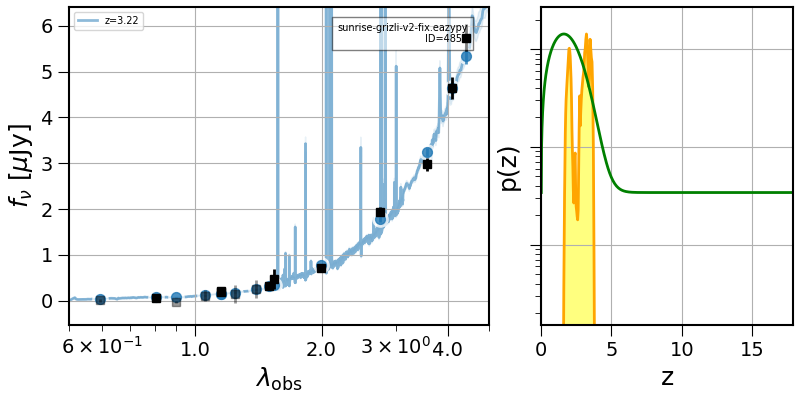

In [43]:
# Show EAZY best SED fit and redshift probability distribution P(z)
fig, data = eazy_run.show_fit(id, xlim=[0.5, 5], show_fnu=True, logpz=True, show_prior=True)

<IPython.core.display.Javascript object>


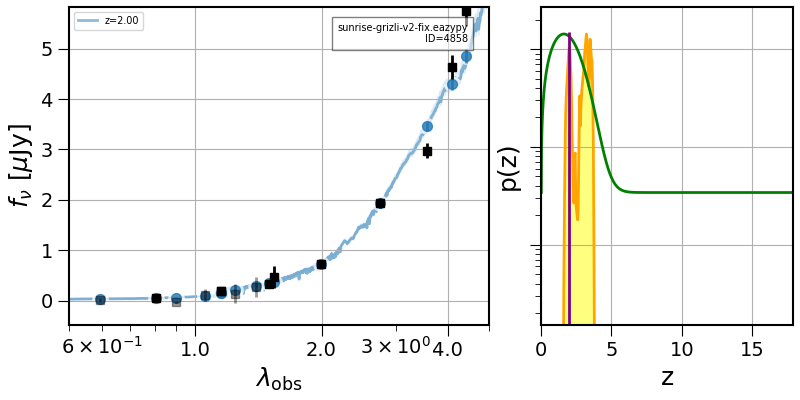

In [44]:
# Show best SED fit for a different redshift (not most likely) with zshow
fig, data = eazy_run.show_fit(id, xlim=[0.5, 5], show_fnu=True, logpz=True, show_prior=True, zshow=2)

In [45]:
# See all properties in the catalog
extract_id(catalog, id)

id,ra,dec,f090w_flux,f090w_fluxerr,f105w_flux,f105w_fluxerr,f110w_flux,f110w_fluxerr,f115w_flux,f115w_fluxerr,f125w_flux,f125w_fluxerr,f140w_flux,f140w_fluxerr,f150w_flux,f150w_fluxerr,f160w_flux,f160w_fluxerr,f200w_flux,f200w_fluxerr,f277w_flux,f277w_fluxerr,f356w_flux,f356w_fluxerr,f410m_flux,f410m_fluxerr,f435w_flux,f435w_fluxerr,f444w_flux,f444w_fluxerr,f475w_flux,f475w_fluxerr,f606w_flux,f606w_fluxerr,f814w_flux,f814w_fluxerr,z_spec,nusefilt,z_ml,z_ml_chi2,z_ml_risk,lc_min,lc_max,z_phot,z_phot_chi2,z_phot_risk,z_min_risk,min_risk,z_raw_chi2,raw_chi2,z025,z160,z500,z840,z975,restU,restU_err,restB,restB_err,restV,restV_err,restJ,restJ_err,dL,Lv,mass,sfr,LIR,energy_abs,Av,lw_age_V,MLv,flux,peak,flux_radius
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,Mpc,solLum,solMass,solMass / yr,solLum,solLum,,Gyr,solMass / solLum,uJy,uJy,
int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,int64,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
4858,24.343239,-8.452273,-0.034,0.030,0.109,0.121,0.204,0.018,0.246,0.028,0.142,0.193,0.264,0.195,0.415,0.024,0.472,0.216,1.005,0.022,2.220,0.019,3.397,0.020,5.113,0.035,0.035,0.072,6.060,0.028,-0.023,0.037,0.013,0.043,0.063,0.026,-1.0,17,3.218401,43.742493,0.34751517,4318.8,44036.7,3.218401,43.742493,0.34751517,3.2204862,0.3475319,3.4814665,43.2986,1.7968,1.9953,3.1187,3.4893,3.6404,0.352,0.024,0.591,0.036,1.120,0.042,7.947,0.978,2.8e+04,3.47e+10,7.79e+10,40.282,2.57e+11,0.00e+00,1.95,-99.00,2.24,0.588514643880369,0.0018450842283410623,14.235506708601982


# Show a galaxy (or any object) detected in the image

<IPython.core.display.Javascript object>


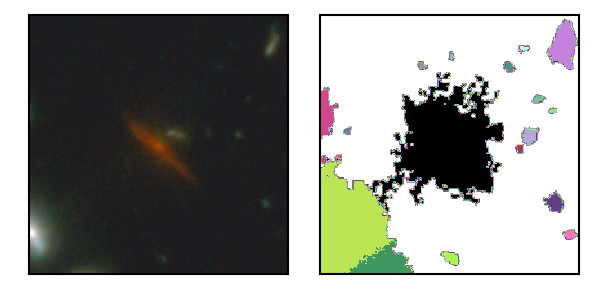

In [46]:
fig = show_galaxy(id, figsize=(6,3))
#fig.savefig('galaxy_%d.png' % id) #, dpi=200)

# Show galaxy and its properties

<IPython.core.display.Javascript object>


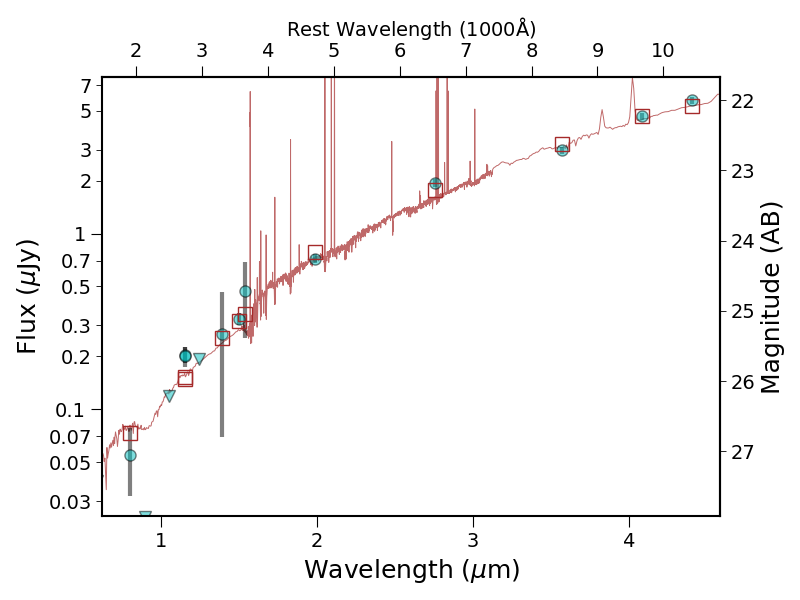

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_SED(id, fig, ax)

In [48]:
data = eazy_run.show_fit(id, show_fnu=True, get_spec=True)
SNR = data['fobs'] / data['efobs']
SNR

array([-1.12881648,  0.90476478,  9.83988512,  8.00154102,  0.73536573,
        1.35371789, 13.03835357,  2.17103426, 18.33755906, 19.70195016,
       19.85642949, 19.81570099,  0.48881718, 19.91545748, -0.62363624,
        0.29577645,  2.36693348])

<IPython.core.display.Javascript object>


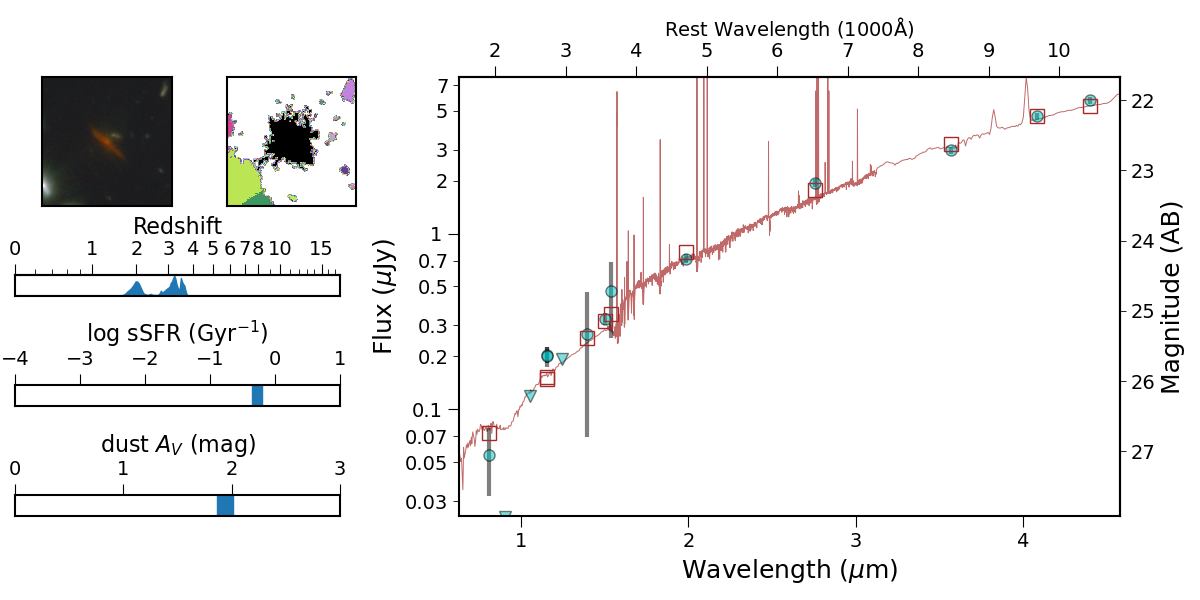

In [49]:
fig = show_galaxy_properties(id, figsize=(12, 6))
#fig.savefig('EAZY_%d.png' % id) #, dpi=200)